# Task A: Deep Learning for ECG Heartbeat Classification

We shall evaluate all models on unseen data by using the models which are only trained on the mitbih_train.csv and we do testing on mitbih_test.csv here

In [1]:
import torch
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.5.1+cu124
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce GTX 1660 SUPER


In [ ]:
import os

import pandas as pd
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from common_utils import get_dataloader

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
test_df = pd.read_csv("Heartbeat_Dataset/mitbih_test.csv")
print(test_df.shape)

(21891, 188)


In [ ]:
test_df.head()

# Evaluation of basic models

In this section, we evaluate 3 base models, namely GRU, CNN and Transformer

In [56]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

test_df.iloc[:, -1] = test_df.iloc[:, -1].replace(labels)

In [ ]:
x_data = test_df.iloc[:, :-1]
y_label = test_df.iloc[:, -1]

In [56]:
y_label.value_counts()

187
N    18118
Q     1608
V     1448
S      556
F      162
Name: count, dtype: int64

In [57]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label) 

X = x_data
X_test = np.expand_dims(X, axis=1)  
print(X_test.shape) 
X_test_tensor = torch.tensor(X_test).float()    
y_test_tensor = torch.tensor(y).long()        

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(21892, 1, 187)


## CNN model

In [ ]:
from common_utils import CNN1D

# Load model
model_path = "./model/cnn_model.pth"
num_classes = len(label_encoder.classes_)
loaded_CNNmodel = CNN1D(num_classes).to(DEVICE)  
loaded_CNNmodel.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
from common_utils import evaluateCNN_model

# Evaluate
test_accuracy = evaluateCNN_model(x_data, y_label, num_classes, loaded_CNNmodel, batch_size=32, device=DEVICE)

Test Accuracy for CNN model: 0.9823


## Transformer model

In [ ]:
# Loading transformer modules and constants
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

batch_size = 128
num_workers = 0

input_size = 200
num_classes = 5
num_heads = 5
depth = 6
max_epochs = 22
lr = 1e-4
dropout = 0.0

In [ ]:
path = "./heartbeat_Dataset"
from transformer_eval import LitTransformer, LitMITBIH
Transformer_model = LitTransformer(input_size, num_classes, num_heads, depth, max_epochs, lr, dropout)
datamodule = LitMITBIH(path, batch_size, num_workers, length=input_size)
datamodule.setup()

In [ ]:
save_path = "./model/"
ckpt_name = "ecg-transformer"

model_checkpoint = ModelCheckpoint(
    dirpath=os.path.join(save_path, "checkpoints"),
    filename=ckpt_name,
    save_top_k=1,
    verbose=True,
    monitor='val_acc',
    # monitor='test_acc',
    mode='max',
)

trainer = Trainer(accelerator="gpu",
                  devices=1,
                  max_epochs=max_epochs,
                  logger=False,
                  callbacks=[model_checkpoint]
                )

print(f"Loading checkpoint: {ckpt_name}.ckpt")
Transformer_model = Transformer_model.load_from_checkpoint(
    os.path.join(save_path, "checkpoints", ckpt_name+".ckpt")
)

trainer.test(Transformer_model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

Loading checkpoint: ecg-transformer.ckpt


You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     97.78797149658203     │
│         test_loss         │    0.11676190793514252    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 97.78797149658203, 'test_loss': 0.11676190793514252}]

## RNN model

In [ ]:
from common_utils import GRUModel

model_path = "./model/gru_rnn_model.pth"
inputSize = 1
hiddenSize = 64
numClasses = 5
numLayers = 1

# Loss
criterion = nn.CrossEntropyLoss()

# Load model
rnn_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses).to(DEVICE)
rnn_model.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded successfully.")

reverse_labels = {v: k for k, v in labels.items()}

# Test dataset for RNN
RNN_X_test = test_df.iloc[:, :-1].values  
RNN_y_test = test_df.iloc[:, -1].replace(reverse_labels).astype(float).values  # Convert labels back to numbers

RNN_X_test = np.reshape(RNN_X_test, (X_test.shape[0], X_test.shape[1], 1))

RNN_test_loader = get_dataloader(RNN_X_test, RNN_y_test, False)

test_loss = 0.0
correct = 0.0
y_pred, y_true = [], []

# Get test results
with torch.no_grad():  # No need to calculate gradients for validation
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        outputs = rnn_model(X_batch)
        loss = criterion(outputs, y_batch.long())
        test_loss += loss.item() * X_batch.size(0)
        
        # Get predictions
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == y_batch).sum().item()

        y_pred.append(predictions.float().detach().cpu())
        y_true.append(y_batch.cpu())

# Calculate average validation loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)

preds = torch.cat(y_pred).numpy()
truths = torch.cat(y_true).numpy()

# Get classification report and confusion matrix
classes = ['N', 'S', 'V', 'F', 'Q']
labels = [0.0, 1.0, 2.0, 3.0, 4.0]
report = pd.DataFrame(classification_report(truths, preds, labels=labels, target_names=classes, output_dict=True)).transpose()
cm = confusion_matrix(truths, preds)

Model loaded successfully.


C:\Users\User\AppData\Local\Temp\ipykernel_21452\1277084343.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  RNN_y_test = test_df.iloc[:, -1].replace(reverse_labels).astype(float).values  # Convert labels back to numbers


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 187

In [ ]:
report

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Shape of X: (21892, 1, 187)
Shape of y: [0. 0. 0. ... 4. 4. 4.]


C:\Users\randa\AppData\Local\Temp\ipykernel_15904\970282232.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  RNN_y_test = test_df.iloc[:, -1].replace(reverse_labels).astype(float).values  # Convert labels back to numbers


These are the results obtained from the different models
| Model        | Test accuracy |
|--------------|---------------|
| CNN          | 0.9823        |
| Transformers | 0.9779        |
| RNN          | 0.8279        |
| RNN(LSTM)    | 0.8278        |
| RNN(GRU)     | 0.9740        |

# Hybrid models

Based on the performance of individual models, we decided to explore hybrid architectures to leverage the strengths of different models. Consequently, we developed Transformer-CNN and CNN-GRU hybrid models. In the following section, we will evaluate the performance of the hybrid models which have been trained on the original and augmented datasets.

## CNN-Transformer Model

In [ ]:
from common_utils import cnn_transformer_evaluate
from CNN_Transformer_hybrid import CNNTransformerHybrid

### Evaluation of model trained on original train data

In [ ]:
model_path = "./model/cnn_transformer_model.pth"

CNN_transformer_model = CNNTransformerHybrid(
    input_dim=187, 
    num_classes=5,  
    num_heads=8, 
    num_layers=6  
).to(DEVICE)

CNN_transformer_model.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded successfully.")

Model loaded successfully.


c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
criterion = torch.nn.CrossEntropyLoss()  

epoch_loss, epoch_acc, all_preds, all_labels = cnn_transformer_evaluate(CNN_transformer_model, test_loader, criterion, DEVICE)
print(f"Loading model from: {model_path}")
print(f"Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.4f}")

Loading model from: ./model/cnn_transformer_model.pth
Test Loss: 0.0666 | Test Accuracy: 0.9850


### Evaluation of model trained on signal transformation data

In [ ]:
model_path = "./model/cnn_transformer_model_augment.pth"

CNN_transformer_model.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded successfully.")

cnn_transformer_augment_epoch_loss, cnn_transformer_augment_epoch_acc, cnn_transformer_augment_all_preds, cnn_transformer_augment_all_labels = cnn_transformer_evaluate(CNN_transformer_model, test_loader, criterion, DEVICE)
print(f"Loading model from: {model_path}")
print(f"Test Loss: {cnn_transformer_augment_epoch_loss:.4f} | Test Accuracy: {cnn_transformer_augment_epoch_acc:.4f}")

Model loaded successfully.
Loading model from: ./model/cnn_transformer_model_augment.pth
Test Loss: 0.0671 | Test Accuracy: 0.9855


### Evaluation of model trained on SMOTE train data

In [ ]:
model_path = "./model/cnn_transformer_model_smote.pth"

CNN_transformer_model.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded successfully.")

cnn_transformer_smote_epoch_loss, cnn_transformer_smote_epoch_acc, cnn_transformer_smote_all_preds, cnn_transformer_smote_all_labels = cnn_transformer_evaluate(CNN_transformer_model, test_loader, criterion, DEVICE)
print(f"Loading model from: {model_path}")
print(f"Test Loss: {cnn_transformer_smote_epoch_loss:.4f} | Test Accuracy: {cnn_transformer_smote_epoch_acc:.4f}")


Model loaded successfully.
Loading model from: ./model/cnn_transformer_model_smote.pth
Test Loss: 0.0920 | Test Accuracy: 0.9828


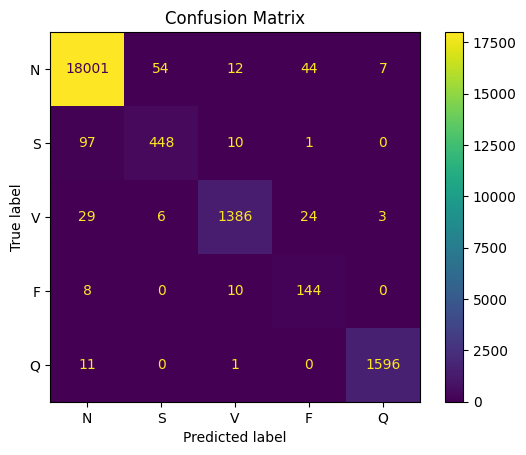

In [ ]:
cm = confusion_matrix(cnn_transformer_augment_all_labels, cnn_transformer_augment_all_preds, labels=[1, 3, 4, 0, 2])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'S', 'V', 'F', 'Q'])
disp.plot( values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [87]:
# preds, truths = test(CNN_transformer_model, test_loader, device)
# report = classification_report(truths, preds, labels=[0.0, 1.0, 2.0, 3.0, 4.0], target_names=['N', 'S', 'V', 'S', 'Q'], output_dict=True)
# conf_matrix = confusion_matrix(truths, preds, labels=[0.0, 1.0, 2.0, 3.0, 4.0])

report = classification_report(cnn_transformer_augment_all_labels, cnn_transformer_augment_all_preds, labels=[1, 3, 4, 0, 2], target_names=['N', 'S', 'V', 'F', 'Q'], output_dict=True)

# Convert the report dictionary to a DataFrame and display
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
N,0.992009,0.993542,0.992775,18118.00000
S,0.881890,0.805755,0.842105,556.00000
V,0.976744,0.957182,0.966864,1448.00000
F,0.676056,0.888889,0.768000,162.00000
Q,0.993773,0.992537,0.993155,1608.00000
accuracy,0.985520,0.985520,0.985520,0.98552
macro avg,0.904095,0.927581,0.912580,21892.00000
weighted avg,0.985994,0.985520,0.985599,21892.00000


Test Loss: 0.0666 | Test Accuracy: 0.9850 \
Test Loss: 0.0714 | Test Accuracy: 0.9857 \
Test Loss: 0.1000 | Test Accuracy: 0.9744

## CNN-GRU model

### Evaluation of model trained on original train data

In [13]:
def test(model, test_loader, device=DEVICE):
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    y_pred, y_true = [], []

    with torch.no_grad():  # No need to calculate gradients for validation/testing
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            test_loss += loss.item() * X_batch.size(0)

            _, predictions = torch.max(outputs, 1)
            correct += (predictions == y_batch).sum().item()

            y_pred.append(predictions.float().detach().cpu())
            y_true.append(y_batch.cpu())

    # Calculate average validation loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    preds = torch.cat(y_pred).numpy()
    truths = torch.cat(y_true).numpy()

    return preds, truths, test_loss, test_acc

In [14]:
# Load test data
test_data = pd.read_csv('Heartbeat_Dataset/mitbih_test.csv', header=None)
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

X_test = np.expand_dims(X_test, axis=1)  # Change axis from 2 to 1

test_loader = get_dataloader(X_test, y_test, is_train=False)

In [ ]:
from common_utils import CNN_GRU

# Load model
cnn_gru_model = CNN_GRU()
model_path = './model/cnn_gru_original.pth'
cnn_gru_model.load_state_dict(torch.load(model_path, weights_only=True))

# Test model
truths, preds, test_loss, test_acc = test(cnn_gru_model, test_loader)

# Get classification report and confusion matrix
classes_list = ['N', 'S', 'V', 'F', 'Q']
labels_list = [0.0, 1.0, 2.0, 3.0, 4.0]
report = pd.DataFrame(classification_report(truths, preds, labels=labels_list, target_names=classes_list, output_dict=True)).transpose()
cm = confusion_matrix(truths, preds)

In [43]:
# Display report
report

,precision,recall,f1-score,support
N,0.995916,0.991647,0.993777,18196.000000
S,0.827338,0.894942,0.859813,514.000000
V,0.955110,0.968487,0.961752,1428.000000
F,0.808642,0.861842,0.834395,152.000000
Q,0.988806,0.992509,0.990654,1602.000000
accuracy,0.987027,0.987027,0.987027,0.987027
macro avg,0.915162,0.941885,0.928078,21892.000000
weighted avg,0.987475,0.987027,0.987207,21892.000000


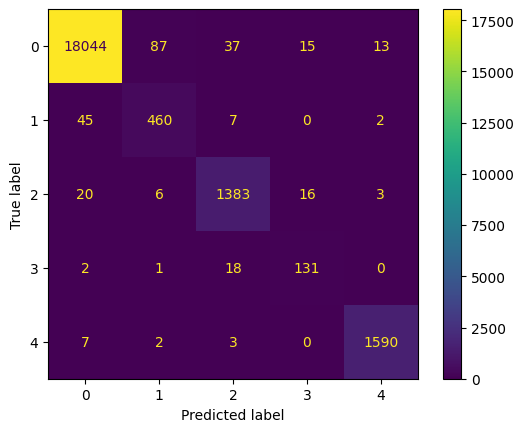

In [44]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Evaluation of model trained on SMOTE train data

In [ ]:
from common_utils import CNN_GRU

# Load model
cnn_gru_model = CNN_GRU()
model_path = './model/cnn_gru_smote.pth'
cnn_gru_model.load_state_dict(torch.load(model_path, weights_only=True))

# Test model
truths, preds, test_loss, test_acc = test(cnn_gru_model, test_loader)

# Get classification report and confusion matrix
report = pd.DataFrame(classification_report(truths, preds, labels=labels_list, target_names=classes_list, output_dict=True)).transpose()
cm = confusion_matrix(truths, preds)

In [46]:
# Display report
report

,precision,recall,f1-score,support
N,0.995088,0.991531,0.993306,18183.00000
S,0.811151,0.893069,0.850141,505.00000
V,0.965470,0.969487,0.967474,1442.00000
F,0.833333,0.849057,0.841121,159.00000
Q,0.990050,0.993138,0.991591,1603.00000
accuracy,0.986890,0.986890,0.986890,0.98689
macro avg,0.919018,0.939256,0.928727,21892.00000
weighted avg,0.987350,0.986890,0.987071,21892.00000


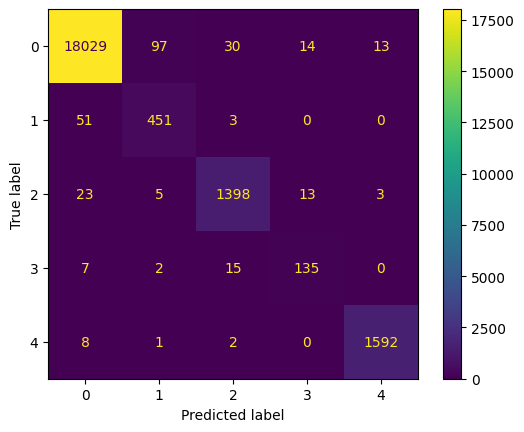

In [47]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Evaluation of model trained on Signal Transformation train data

In [ ]:
from common_utils import CNN_GRU

# Load model
cnn_gru_model = CNN_GRU()
model_path = './model/cnn_gru_st.pth'
cnn_gru_model.load_state_dict(torch.load(model_path, weights_only=True))

# Test model
truths, preds, test_loss, test_acc = test(cnn_gru_model, test_loader)

# Get classification report and confusion matrix
report = pd.DataFrame(classification_report(truths, preds, labels=labels_list, target_names=classes_list, output_dict=True)).transpose()
cm = confusion_matrix(truths, preds)

In [49]:
# Display report
report

,precision,recall,f1-score,support
N,0.996081,0.992029,0.994051,18192.000000
S,0.814748,0.907816,0.858768,499.000000
V,0.964088,0.974180,0.969108,1433.000000
F,0.839506,0.809524,0.824242,168.000000
Q,0.991294,0.996250,0.993766,1600.000000
accuracy,0.987849,0.987849,0.987849,0.987849
macro avg,0.921144,0.935960,0.927987,21892.000000
weighted avg,0.988302,0.987849,0.988011,21892.000000


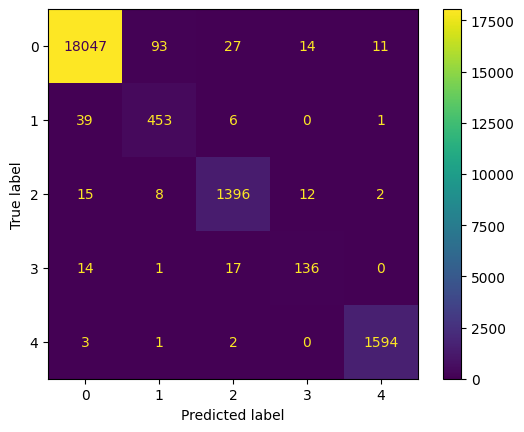

In [50]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()